### 1. Обучение классификатора картинок на примере CIFAR-100 сверточной сетью (самописной):

In [ ]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

def train_valid_split(Xt):
  X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
  return X_train, X_test

class MyOwnCifar(torch.utils.data.Dataset):

  def __init__(self, init_dataset, transform=None):
    self._base_dataset = init_dataset
    self.transform = transform

  def __len__(self):
    return len(self._base_dataset)

  def __getitem__(self, idx):
    img = self._base_dataset[idx][0]
    if self.transform is not None:
      img = self.transform(img)
    return img, self._base_dataset[idx][1]



Files already downloaded and verified


In [ ]:

trans_actions = transforms.Compose([transforms.Scale(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
def show_batch(dl):
    for batch in dl:
        images,labels = batch
        fig, ax = plt.subplots(figsize=(7.5,7.5))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(make_grid(images[:20],nrow=5).permute(1,2,0))
        break

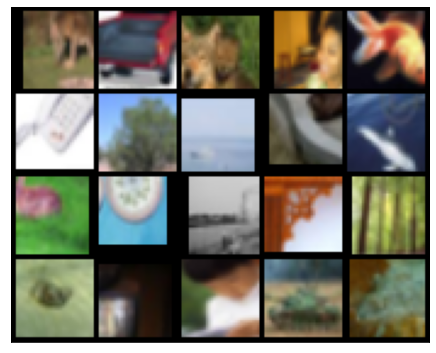

In [ ]:
show_batch(train_loader)

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.dp_three = nn.Dropout(0.2)
    self.dp_four = nn.Dropout(0.2)

    self.bn_one = torch.nn.BatchNorm2d(3)
    self.conv_one = torch.nn.Conv2d(3, 30, 3)
    self.bn_two = torch.nn.BatchNorm2d(30)
    self.conv_two = torch.nn.Conv2d(30, 60, 3)
    self.bn_three = torch.nn.BatchNorm2d(60)
    self.conv_three = torch.nn.Conv2d(60, 120, 3)
    self.bn_four = torch.nn.BatchNorm2d(120)
    self.fc1 = torch.nn.Linear(2160, 1080)
    self.fc2 = torch.nn.Linear(1080, 540)
    self.out = torch.nn.Linear(540, 100)

  
  def forward(self, x):
    #print(f"1x {x.shape}")
    x = self.bn_one(x)
    #print(f"2x {x.shape}")
    x = self.conv_one(x)
    #print(f"3x {x.shape}")
    x = F.relu(x)
    #print(f"4x {x.shape}")
    x = F.max_pool2d(x, 2)
    #print(f"5x {x.shape}")

    x = self.bn_two(x)
    #print(f"6x {x.shape}")
    x = self.conv_two(x)
    #print(f"7x {x.shape}")
    x = F.relu(x)
    #print(f"8x {x.shape}")
    x = F.max_pool2d(x, 2)
    #print(f"9x {x.shape}") # torch.Size([128, 60, 6, 6])

    x = self.bn_three(x)
    #print(f"10x {x.shape}")
    x = x.view(x.size(0), -1)
    #print(f"11x {x.shape}")
    x = self.dp_three(x)
    #print(f"12x {x.shape}") # torch.Size([128, 2160]) #(128x2160 and 480x200)
    x = self.fc1(x)
    #print(f"13x {x.shape}")
    x = F.relu(x)
    #print(f"14x {x.shape}")
    x = self.dp_four(x)
    #print(f"15x {x.shape}")
    x = self.fc2(x)
    #print(f"16x {x.shape}")
    x = F.relu(x)
    #print(f"17x {x.shape}")

    return self.out(x)

net = Net()
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2160, out_features=1080, bias=True)
  (fc2): Linear(in_features=1080, out_features=540, bias=True)
  (out): Linear(in_features=540, out_features=100, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in tqdm(range(10)):
  net.train()
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0], data[1]
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  net.eval()
  loss_accumed = 0
  for X, y in valid_loader:
    output = net(X)
    loss = criterion(output, y)
    loss_accumed += loss
  print("Epoch {} vlaid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

 10%|█         | 1/10 [01:26<12:54, 86.07s/it]

Epoch 0 vlaid_loss 91.98402404785156


 20%|██        | 2/10 [02:53<11:33, 86.70s/it]

Epoch 1 vlaid_loss 92.1533203125


 30%|███       | 3/10 [04:32<10:46, 92.39s/it]

Epoch 2 vlaid_loss 92.21344757080078


 40%|████      | 4/10 [06:18<09:46, 97.79s/it]

Epoch 3 vlaid_loss 92.19599914550781


 50%|█████     | 5/10 [08:01<08:17, 99.56s/it]

Epoch 4 vlaid_loss 92.19452667236328


 60%|██████    | 6/10 [09:41<06:39, 99.99s/it]

Epoch 5 vlaid_loss 92.16812133789062


 70%|███████   | 7/10 [11:25<05:03, 101.06s/it]

Epoch 6 vlaid_loss 92.15538787841797


 80%|████████  | 8/10 [13:07<03:23, 101.61s/it]

Epoch 7 vlaid_loss 92.19902801513672


 90%|█████████ | 9/10 [14:50<01:41, 101.84s/it]

Epoch 8 vlaid_loss 92.17497253417969


100%|██████████| 10/10 [16:30<00:00, 99.01s/it] 

Epoch 9 vlaid_loss 92.13272094726562
Training is finished!


### 2. Обучение классификатора картинок на примере CIFAR-100 через дообучение ImageNet Resnet-50

In [ ]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)

In [ ]:
# Необходимые трансформации

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), normalize, transforms.ToTensor()])

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.set_parameter_requires_grad = False

In [ ]:
set_parameter_requires_grad(resnet50, True)
resnet50.fc = nn.Linear(2048, 100)

In [ ]:
trans_actions = transforms.Compose([transforms.Scale(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=64,
                                           shuffle=False,
                                           num_workers=1)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
params_to_update = []

for name, param in resnet50.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in tqdm(range(10)):
  resnet50.train()
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0], data[1]
    optimizer.zero_grad()

    outputs = resnet50(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  resnet50.eval()
  loss_accumed = 0
  
  for X, y in valid_loader:
    output = resnet50(X)
    loss = criterion(output, y)
    loss_accumed += loss
  print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

  0%|          | 0/10 [00:00<?, ?it/s]